To - Do:
- add tech model
- add function to compare models
- edit for clarity
- add references



## Promotion Analysis using Logistic Regression
The purpose of this analysis is to estimate a model to determine the factors that influence an employee at a multinational corporation receiving a promotion. I will use a synthesized data set to demonstrate how to perform logistic regression and interpret the regression coefficients. These coefficients communicate the strength and direction of the relationships between the explanatory variables and the outcome variable, promotion, to explain which holds the most weight.

### Assumptions of Logistic Regression
There are six assumptions of binary logistic regression that a model must meet to ensure the validity of its results.  
1. There are only two options for the response variable (promoted/not promoted)
2. The observations are independent; the data can't have multiple promotions for a given employee
3. Explanatory variables can't be highly correlated. For example, we'd probably expect top performers to have higher test scores; we'd need to check for correlation before including both.
4. The data shouldn't have extreme outliers or influential points. Influential points are more useful when data is formatted as a crosstab than when it's ungrouped (Agresti)
5. The relationship between continuous predictors and the logit is linear. You can check this assumption using the Box-Tidwell transformation
6. There is a large sample size. The rule of thumb is that there's a minimum of 10 cases of the least frequent outcome. For example, if there are 50 promotions in the data, you can have five predictor variables. However, when your predictor variables are solely categorical, you can run a crosstab to see if at least 80% of your cells have an expected value of 5 or more with no values less than 1

### Model Building
I am going to be build separate models for three departments - HR, Technology, and Operations so we can isolate the key influences for promotions in each unit. An alternative is to build a Generalized Linear Mixed Model which is a form of regression used with hierarchical or nested data - like departments.

### Variable Selection
For the initial variable selection, I'll use generation, gender, region, awards won, variables related to performance. The key here is to include the factors that you think might be a factor in the promotion process at your organization.   



In [1]:
# import data vis modules
import log_plots as plots

# import data management modules
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

# import stats modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# import rpy2 for r stats modules
import rpy2



In [2]:
# read in employee promotion dataset
df = pd.read_csv('..\data\input\employee_promotion.csv', dtype = {'employee_id':'str'})

# create tenure bands based on employee length of service
df['tenure_bands'] = df.length_of_service.apply(lambda x: '0-2' if x < 2 else '2-4' if x <4 else '4+')


# takes log of length of service bc data is skewed
df['log_los'] = np.log(df.length_of_service)

# fill average training score with 0 for employees mising scores
df.avg_training_score.fillna(0, inplace = True)

# create generations based on employee ages
df['age_group'] = df.age.apply(lambda x: 'gen_z' if x <= 25 
                               else 'mill' if x <=41 
                               else 'gen_x' if x<=57 
                               else 'baby_boomer')


# fill na education data
df['education'] = df.education.fillna('no education data')

# create groups for trainings
df['trainings'] = df.no_of_trainings.apply(lambda x: '1' if x == 1 else '2 or more')

# fill na for previous year rating
df['previous_year_rating'] = df.previous_year_rating.fillna('unrated')

# create talent groups of high, medium, low and unrated
df['talent_group'] = df.previous_year_rating.apply(lambda x: 'unrated' if x == 'unrated' else 'high' if x in [4.0,5.0] 
                              else 'medium' if x == 3.0 else 'low')

# create binary variable indicating high performer - someone scored in the top 2 tiers
df['high_performer'] = df.previous_year_rating.apply(lambda x: 1 if x in [4.0,5.0] else 0)

# gets size ordered list of departments
size_order = df.department.value_counts().sort_values().index 


In [3]:
# get count of promotions by department
promos_by_dept = df.pivot_table(index = 'department', columns = 'is_promoted', # creates pivot table of ees by promo and dept
                                values = 'employee_id', aggfunc = 'count')

# create contingency table
tab_dept = sm.stats.Table(promos_by_dept)

In [4]:
# creates new dataframe with observed promotion counts
promos_by_dept_fitted = promos_by_dept.copy().rename(columns = {1:'observed'})

# appends expected promotion counts
promos_by_dept_fitted = pd.concat([promos_by_dept_fitted,tab_dept.fittedvalues], axis = 1).rename(columns = {1:'expected'})

# limits columns to observed and expected
promos_by_dept_fitted = promos_by_dept_fitted[['observed','expected']].copy()

# reorders rows in size order
promos_by_dept_fitted = promos_by_dept_fitted.reindex(size_order)

## Chi-Square Analysis of Promotions by Department
The chi-square analysis compares the overall organization promotion rate of 9% to the promotion rate by department. The expected values for promoted employees by department would be very close to the marginal probability if there isn't an association based on department. The chi-square statistic is the sum of the difference between the observed and expected values for each cell in the contingency table. This value gets compared to the chi-square distribution to see if it's statistically significant.

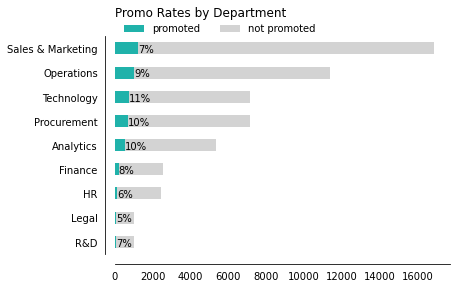

```python
# create a contigency table based on counts of employees by promotion status and department
tab_dept = sm.stats.Table(promos_by_dept)

# run the chi-square test of association 
tab_dept.test_nominal_association().pvalue

# gets critical value for large contingency tables
cells = promos_by_dept.count().sum()
stats.norm.ppf(.05/cells/2)
# returns -2.99

```
Since p < 0.01, the test indicates an association between promotion status and department. We can calculate the standardized values for each cell; any values greater than approximately +/-3 would be considered unusual.


```python
# calculates the standardized residuals for each cell
tab_dept.standardized_resids
```

| department        |         0 |         1 |
|:------------------|----------:|----------:|
| Analytics         | -2.89564  |  2.89564  |
| Finance           |  0.727811 | -0.727811 |
| HR                |  5.21181  | -5.21181  |
| Legal             |  3.98255  | -3.98255  |
| Operations        | -2.13343  |  2.13343  |
| Procurement       | -3.63993  |  3.63993  |
| R&D               |  1.83999  | -1.83999  |
| Sales & Marketing |  7.33903  | -7.33903  |
| Technology        | -7.2773   |  7.2773   |


There are fewer promotions than expected in HR, Legal, and Sales & Marketing, and more than expected in Technology and Procurement.

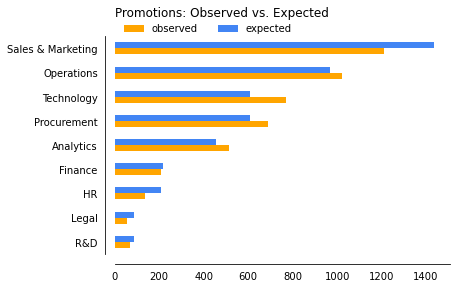

## Model for the HR Department

The chi-square analysis showed that the HR department had fewer promotions than expected. I will follow the purposeful selection of explanatory variables outlined in Agresti 2017 to identify the variables that provide the best fit. The table below summarizes the models fit with age group, gender, tenure bands, awards won, high performer, and region groups as potential explanatory variables.

The AIC for the null model isn't provided in the GLM results. It is calculated as -2(log-likelihood) + 2K where K is the number of parameters.

```python
# Calculate AIC for the null model
#llnull is the log likelihood for the null model and the intercept is the only predictor
(-2*res.llnull) + 2

```

|model| explanatory variables        | Deviance|  df | AIC | Models Compared| Deviance Difference |
|:----|-----------------------------:|:-------:|----:|----:| --------------:|--------------------:|
|null |                              | 1047    |2417 |1049 |                |                     |
|mod| gender        | 1047|  2416 | 1051 | null| 0.06 (df = 1)|
|mod1| age group        | 1046|  2414 | 1054 | null| 0.92 (df = 3) |
|mod2| tenure bands       | 1045.7|  2415 | 1052 | null| 1.35 (df = 2) |
|mod3| awards won        | 998.89|  2416 | 1003 | null| 48.14 (df = 1) |
|mod4| high performer        | 1030.1|  2416 | 1034 | null| 16.91 (df = 1) |
|mod5| region groups        | 1043.8|  2412 | 1056 | null| 3.24 (df = 5) |
|mod6| awards won + high performer        | 983.57|  2415 | 990 | mod3: awards won| 15.32 (df = 1) |
||         | |   |  | mod4: high performer| 46.55 (df = 1) |


### Multicollinearity
The final model indicates that high performance and winning an award are the strongest predictors of whether an employee in the HR department receives a promotion. Since both explanatory variables are categorical, we can use a chi-square test to assess whether the two variables are associated. With a p > 0.05, we fail to reject the null hypothesis that awards won and high performance are associated.

```python
# an indication of multicollinearity is if the model is significant but the individual predictors are not
# can also use a chi-square test to check if there's association between awards_won and talent group
sm.stats.Table.from_data(hr[['awards_won','high_performer']]).test_nominal_association().pvalue
```

### Influential Points
We can convert our data to a crosstab and rerun the model which makes it easier to assess the standardized residuals 

```python
# model using grouped data 

mod_grouped = smf.glm('yes + no ~ awards_won + high_performer', 
               family=sm.families.Binomial(), data = awards_hipo_promos)
res_grouped = mod_grouped.fit()
res_grouped.summary()

```

|    |   dfb_Intercept |   dfb_awards_won |   dfb_high_performer |   cooks_d |   standard_resid |   hat_diag |   dffits_internal |
|---:|----------------:|-----------------:|---------------------:|----------:|-----------------:|-----------:|------------------:|
|  0 |       -3.11436  |         0.640813 |             2.29759  |  3.23308  |        -0.707688 |   0.9509   |         -3.11436  |
|  1 |        0.160811 |        -0.781542 |             2.29759  |  4.27869  |         0.707688 |   0.962448 |          3.58275  |
|  2 |        0.160811 |         0.640813 |            -0.217978 |  0.166694 |         0.707688 |   0.499629 |          0.707164 |
|  3 |        0.160811 |        -0.781542 |            -0.217978 |  0.237296 |        -0.707688 |   0.587022 |         -0.843735 |

### Parameters
|                |   coefficients |
|:---------------|---------------:|
| Intercept      |      -3.2962   |
| awards_won     |       2.51517  |
| high_performer |       0.709667 |

In [5]:
# creates dataframe of HR employees
hr = df.loc[df.department == 'HR'].copy()

# gets the top 5 most populous regions
top_locs = hr['region'].value_counts()[:5].index

# creates groups isolating the largest regions and consolidating the rest as other
hr['region_grps'] = hr['region'].apply(lambda x: x if x in top_locs else 'other')

# calculates the 90th percentile for training score
top_score = np.percentile(hr.avg_training_score, 90)

# creates binary variable if they're in the top score
hr['top_score'] = hr.avg_training_score.apply(lambda x: 1 if x>= top_score else 0)



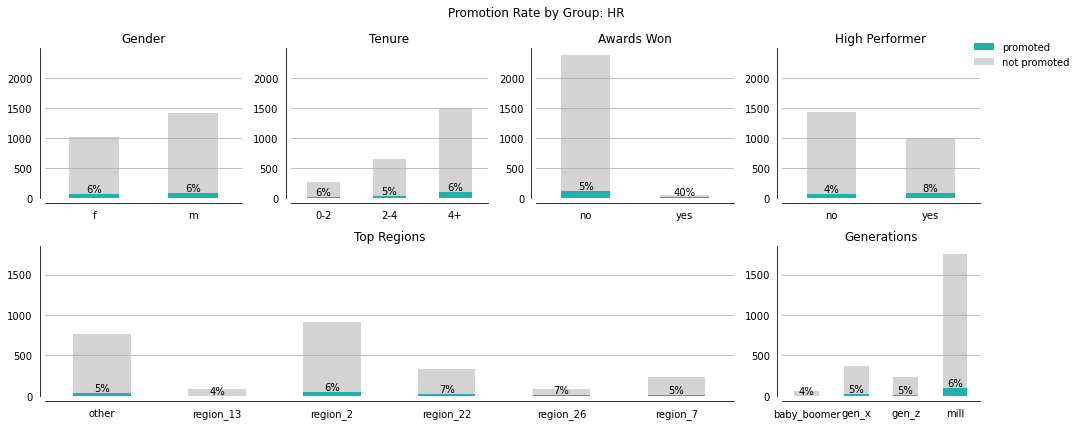

In [6]:
plots.plot_promo_demographics(hr, 'HR')

In [7]:
mod = smf.glm('is_promoted ~ C(gender,Treatment("m"))', 
               family = sm.families.Binomial(), data = hr) 
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2416
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -523.48
Date:                Wed, 26 Jan 2022   Deviance:                       1047.0
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):          2.660e-05
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.8392      0.116    -24.373      0.000      -3.068      -2.611
C(gender, Treatment("m"))[T.f]     0.0453      0.179      0.254      0.800      -0.305       0.395
==================================================================================================
"""

In [8]:
# llr is difference in null model and saturated model
llr=round(res.null_deviance-res.deviance,2)
print(f'llr: {llr}')

p_val=round(1-stats.chi2.cdf(llr,res.df_model),4)
print(f'p-value:{p_val} ')

llr: 0.06
p-value:0.8065 


In [9]:
mod1 = smf.glm('is_promoted ~ C(age_group,Treatment("gen_z"))', 
               family = sm.families.Binomial(), data = hr) 
res1 = mod1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2414
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -523.05
Date:                Wed, 26 Jan 2022   Deviance:                       1046.1
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0003820
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -2.9223      0.296     -9.861      0.000      -3.503      -2.341
C(age_group, Treatment("gen_z"))[T.baby_boomer]    -0.3549      0.779     -0.456      0.649      -1.881       1.172
C(age_group, Treatment("gen_z"))[T.gen_x]           0.0088      0.379      0.023      0.982      -0.733       0.751
C(age_group, Treatment("gen_z"))[T.mill]            0.1448      0.313      0.462      0.644      -0.469       0.759
===================================================================================================================
"""

In [10]:
# llr is difference in null model and saturated model
llr1=round(res1.null_deviance-res1.deviance,2)
print(f'llr: {llr1}')

p_val1=round(1-stats.chi2.cdf(llr1,res1.df_model),4)
print(f'p-value:{p_val1} ')

llr: 0.92
p-value:0.8206 


In [11]:
# box tidwell test of linearity in the logit
# if the interaction of the log of the continuous variable and the non-transformed variable isn't significant 
# then the assumption of linearity passes
# need to add a constant to the original variable if the min value is 0 or less
mod_bt = smf.glm('is_promoted ~ length_of_service + length_of_service:log_los',
             family = sm.families.Binomial(), data = hr)
res_bt = mod_bt.fit()
res_bt.summary()

# in practice would use tenure bands

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2415
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -523.18
Date:                Wed, 26 Jan 2022   Deviance:                       1046.4
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0002744
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.9788      0.330     -9.034      0.000      -3.625      -2.333
length_of_service             0.0965      0.152      0.633      0.526      -0.202       0.395
length_of_service:log_los    -0.0346      0.050     -0.690      0.490      -0.133       0.064
=============================================================================================
"""

In [12]:
mod2 = smf.glm('is_promoted ~ tenure_bands', 
               family = sm.families.Binomial(), data = hr) 
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2415
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -522.84
Date:                Wed, 26 Jan 2022   Deviance:                       1045.7
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0005601
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.8094      0.266    -10.567      0.000      -3.330      -2.288
tenure_bands[T.2-4]    -0.1879      0.323     -0.581      0.561      -0.822       0.446
tenure_bands[T.4+]      0.0564      0.287      0.197      0.844      -0.507       0.619
=======================================================================================
"""

In [13]:
# llr is difference in null model and saturated model
llr2=round(res2.null_deviance-res2.deviance,2)
print(f'llr: {llr2}')

p_val2=round(1-stats.chi2.cdf(llr2,res2.df_model),4)
print(f'p-value:{p_val2} ')

llr: 1.35
p-value:0.5092 


In [14]:
mod3 = smf.glm('is_promoted ~ awards_won', 
               family = sm.families.Binomial(), data = hr) 
res3 = mod3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2416
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -499.45
Date:                Wed, 26 Jan 2022   Deviance:                       998.89
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01971
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9502      0.094    -31.241      0.000      -3.135      -2.765
awards_won     2.5448      0.319      7.987      0.000       1.920       3.169
==============================================================================
"""

In [15]:
# llr is difference in null model and saturated model
llr3=round(res3.null_deviance-res3.deviance,2)
print(f'llr: {llr3}')

p_val3=round(1-stats.chi2.cdf(llr3,res3.df_model),4)
print(f'p-value:{p_val3} ')

llr: 48.14
p-value:0.0 


In [16]:
mod4 = smf.glm('is_promoted ~ high_performer', 
               family = sm.families.Binomial(), data = hr) 
res4 = mod4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2416
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -515.06
Date:                Wed, 26 Jan 2022   Deviance:                       1030.1
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.006967
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.1781      0.135    -23.509      0.000      -3.443      -2.913
high_performer     0.7297      0.179      4.077      0.000       0.379       1.080
==================================================================================
"""

In [17]:
# llr is difference in null model and saturated model
llr4=round(res4.null_deviance-res4.deviance,2)
print(f'llr: {llr4}')

p_val4=round(1-stats.chi2.cdf(llr4,res4.df_model),4)
print(f'p-value:{p_val4} ')

llr: 16.91
p-value:0.0 


In [18]:
mod5 = smf.glm('is_promoted ~ region_grps', 
               family = sm.families.Binomial(), data = hr) 
res5 = mod5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2412
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -521.89
Date:                Wed, 26 Jan 2022   Deviance:                       1043.8
Time:                        17:09:30   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001340
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9500      0.166    -17.727      0.000      -3.276      -2.624
region_grps[T.region_13]    -0.3335      0.611     -0.546      0.585      -1.531       0.864
region_grps[T.region_2]      0.1622      0.218      0.742      0.458      -0.266       0.590
region_grps[T.region_22]     0.4044      0.269      1.501      0.133      -0.124       0.933
region_grps[T.region_26]     0.2991      0.454      0.659      0.510      -0.591       1.189
region_grps[T.region_7]      0.0232      0.340      0.068      0.946      -0.643       0.689
============================================================================================
"""

In [19]:
# llr is difference in null model and saturated model
llr5=round(res5.null_deviance-res5.deviance,2)
print(f'llr: {llr5}')

p_val5=round(1-stats.chi2.cdf(llr5,res5.df_model),4)
print(f'p-value:{p_val5} ')

llr: 3.24
p-value:0.663 


In [20]:
mod6 = smf.glm('is_promoted ~ awards_won + high_performer', 
               family = sm.families.Binomial(), data = hr) 
res6 = mod6.fit()
res6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 2418
Model:                            GLM   Df Residuals:                     2415
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -491.79
Date:                Wed, 26 Jan 2022   Deviance:                       983.57
Time:                        17:09:30   Pearson chi2:                 2.40e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02590
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.2962      0.140    -23.492      0.000      -3.571      -3.021
awards_won         2.5152      0.323      7.785      0.000       1.882       3.148
high_performer     0.7097      0.183      3.885      0.000       0.352       1.068
==================================================================================
"""

In [21]:
# llr is difference in null model and saturated model
llr6=round(res6.null_deviance-res6.deviance,2)
print(f'llr: {llr6}')

p_val6=round(1-stats.chi2.cdf(llr6,res6.df_model),4)
print(f'p-value:{p_val6} ')

llr: 63.46
p-value:0.0 


In [22]:
# compare model with talent group and awards_won to the model with awards only
llr6a=round(res3.deviance-res6.deviance,2)
print(f'llr: {llr6a}')

p_val6a=round(1-stats.chi2.cdf(llr6a,res6.df_model - res3.df_model),4)
print(f'p-value:{p_val6a} ')

llr: 15.32
p-value:0.0001 


In [23]:
# compare model with high performer and awards_won to the model with high performer only
llr6b=round(res4.deviance-res6.deviance,2)
print(f'llr: {llr6b}')

p_val6b=round(1-stats.chi2.cdf(llr6b,res6.df_model - res4.df_model),4)
print(f'p-value:{p_val6b}')


# awards won seems to be a stronger predictor than talent_group, but would leave both in as it's expected

llr: 46.55
p-value:0.0


In [24]:
# an indication of multicollinearity is if the model is significant but the individual predictors are not
# can also use a chi-square test to check if there's association between awards_won and talent group
sm.stats.Table.from_data(hr[['awards_won','high_performer']]).test_nominal_association().pvalue

0.16681212400203504

In [25]:
# Binomial Format shows success and failures for records with the same covariates
awards_hipo_promos = hr.groupby(['awards_won','high_performer', 
                                   'is_promoted'])['employee_id'].count().unstack('is_promoted').reset_index()
awards_hipo_promos.rename(columns = {1:'yes', 0:'no'}, inplace = True)

awards_hipo_promos.fillna(0,inplace=True)

In [26]:
# model using grouped data 

mod_grouped = smf.glm('yes + no ~ awards_won + high_performer', 
               family=sm.families.Binomial(), data = awards_hipo_promos)
res_grouped = mod_grouped.fit()
res_grouped.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          ['yes', 'no']   No. Observations:                    4
Model:                            GLM   Df Residuals:                        1
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9.6380
Date:                Wed, 26 Jan 2022   Deviance:                      0.49527
Time:                        17:09:30   Pearson chi2:                    0.501
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.2962      0.140    -23.492      0.000      -3.571      -3.021
awards_won         2.5152      0.323      7.785      0.000       1.882       3.148
high_performer     0.7097      0.183      3.885      0.000       0.352       1.068
==================================================================================
"""

In [27]:
# when the predictors are solely categorical and logistic regression is performed on the contigency table
# goodness-of-fit can be measured using the deviance; large deviance indicates lack of fit
# deviance follows a chi-square distribution if at least 80% of the expected values are at least 5
# null hypothesis is that the model that we built is no different than the saturated model

p_val_res_grouped=round(1 - stats.chi2.cdf(res_grouped.deviance, res_grouped.df_resid),5)
p_val_res_grouped

# with p > 0.05 we fail to reject the null hypothesis; the model fits decently 

0.48159

In [28]:
res_grouped.get_influence().summary_frame()

,dfb_Intercept,dfb_awards_won,dfb_high_performer,cooks_d,standard_resid,hat_diag,dffits_internal
0,-3.11436,0.64081,2.29759,3.23308,-0.70769,0.95090,-3.11436
1,0.16081,-0.78154,2.29759,4.27869,0.70769,0.96245,3.58275
2,0.16081,0.64081,-0.21798,0.16669,0.70769,0.49963,0.70716
3,0.16081,-0.78154,-0.21798,0.23730,-0.70769,0.58702,-0.84373


In [29]:
# can add the fitted values from the model to our dataframe and observe that all of the expected values are at least 5
awards_hipo_promos['fitted_yes'] = res_grouped.fittedvalues * (awards_hipo_promos.yes + awards_hipo_promos.no)
awards_hipo_promos['fitted_no'] = (1 - res_grouped.fittedvalues) * (awards_hipo_promos.yes + awards_hipo_promos.no)
awards_hipo_promos[['fitted_yes','fitted_no']]

is_promoted,fitted_yes,fitted_no
0,50.08984,1352.91016
1,67.91016,902.08984
2,6.91016,15.08984
3,11.08984,11.91016


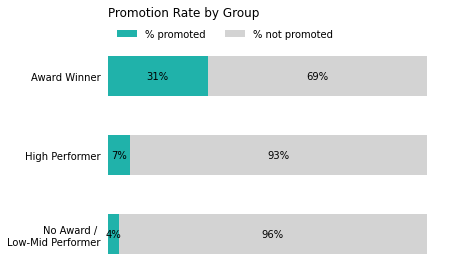

In [30]:
pct_promoted = res_grouped.fittedvalues.sort_values()[:3]
labels = ['No Award / \nLow-Mid Performer', 'High Performer', 'Award Winner']
plots.plot_fitted_values(labels, pct_promoted)

## Model for the Operations Department

The chi-square analysis showed that the Operations department had the expected number of promotions. I will follow the same procedure that I used above to identify the variables that provide the best fit. The table below summarizes the models fit with age group, gender, tenure bands, awards won, high performer, and region groups as potential explanatory variables.

The AIC for the null model isn't provided in the GLM results. It is calculated as -2(log-likelihood) + 2K where K is the number of parameters.

```python
# Calculate AIC for the null model
#llnull is the log likelihood for the null model and the intercept is the only predictor
# alternatively add 2 to the deviance
(-2*res.llnull) + 2

```


|model| explanatory variables        | Deviance|  df | AIC | Models Compared| Deviance Difference |
|:----|-----------------------------:|:-------:|----:|----:| --------------:|--------------------:|
|null |                              | 6874.17    |11347 |6876.17 |                |                     |
|mod| gender        | 6872.3|  11346 | 6876.33 | null| 1.83 (df = 1)|
|mod1| age group        | 6858.0|  11345 | 6865.96 | null| 16.21 (df = 3) |
|mod2| tenure bands       | 6857.9|  11345 | 6863.90 | null| 16.27 (df = 2) |
|mod3| awards won        | 6597.7|  11346 | 6601.70 | null| 276.47 (df = 1) |
|mod4| high performer        |6831.5|  11346 | 6835.53 | null| 42.64 (df = 1) |
|mod5| region groups        | 6830.6|  11344 | 6838.55 | null| 43.62 (df = 5) |
|mod6| awards won + high performer |6554.9|  11345 | 6560.87 | mod3: awards won| 15.32 (df = 1) |
||         | |   |  | mod4: high performer| 46.55 (df = 1) |


### Multicollinearity
High performance and winning an award are the strongest predictors of whether an employee in the Operations department receives a promotion. However, with the exception of gender, the variables considered can be used to explain the odds of promotion. A series of chi-square tests were performed to see if there is any association between these categorical variables. The results of these tests indicate an association between:
- age group and tenure
- high performer and tenure
- high performer and region
- high performer and age group

Based on these results, we can eliminate tenure bands, region groups and age group from our final model

```python
## Check for correlation between categorical variables
awards_performer = round(sm.stats.Table.from_data(ops[['awards_won','high_performer']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of awards_won and high_performer is {awards_performer}')

# p-value of the chi-square test of awards_won and high_performer is 0.536

age_tenure = round(sm.stats.Table.from_data(ops[['age_group','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of age_group and tenure is {age_tenure}')

# p-value of the chi-square test of age_group and tenure is 0.0

awards_tenure = round(sm.stats.Table.from_data(ops[['awards_won','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of awards and tenure is {awards_tenure}')

# p-value of the chi-square test of awards and tenure is 0.605

high_perf_tenure = round(sm.stats.Table.from_data(ops[['high_performer','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and tenure is {high_perf_tenure}')

# p-value of the chi-square test of high performer and tenure is 0.0

high_perf_region = round(sm.stats.Table.from_data(ops[['high_performer','region_grps']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and region is {high_perf_region}')

# p-value of the chi-square test of high performer and region is 0.004

high_perf_age = round(sm.stats.Table.from_data(ops[['high_performer','age_group']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and age group is {high_perf_age}')

# p-value of the chi-square test of high performer and age group is 0.0

```


### Influential Points
We can convert our data to a crosstab and rerun the model which makes it easier to assess the standardized residuals 

```python
# model using grouped data 

ops_mod_grouped = smf.glm('yes + no ~ awards_won + high_performer', 
               family=sm.families.Binomial(), data = ops_awards_hipo)
ops_res_grouped = ops_mod_grouped.fit()
ops_res_grouped.summary()


inf = ops_res_grouped.get_influence()
inf.summary_frame()

```

|    |   dfb_Intercept |   dfb_awards_won |   dfb_high_performer |   cooks_d |   standard_resid |   hat_diag |   dffits_internal |
|---:|----------------:|-----------------:|---------------------:|----------:|-----------------:|-----------:|------------------:|
|  0 |        4.72153  |        -0.958557 |            -3.57298  |  7.43095  |          1.01723 |   0.955642 |           4.72153 |
|  1 |       -0.219158 |         1.0795   |            -3.57298  | 10.9197   |         -1.01723 |   0.96938  |          -5.72356 |
|  2 |       -0.219158 |        -0.958557 |             0.289607 |  0.365797 |         -1.01723 |   0.514687 |          -1.04756 |
|  3 |       -0.219158 |         1.0795   |             0.289607 |  0.439507 |          1.01723 |   0.56029  |           1.14827 |


### Parameters
|                |   coefficients |
|:---------------|---------------:|
| Intercept      |      -2.67037  |
| awards_won     |       2.34779  |
| high_performer |       0.442539 |

In [31]:
ops = df.loc[df.department == 'Operations'].copy()
top_locs = ops['region'].value_counts()[:3].index # gets list of 3 largest locations
ops['region_grps'] = ops['region'].apply(lambda x: x if x in top_locs else 'other')

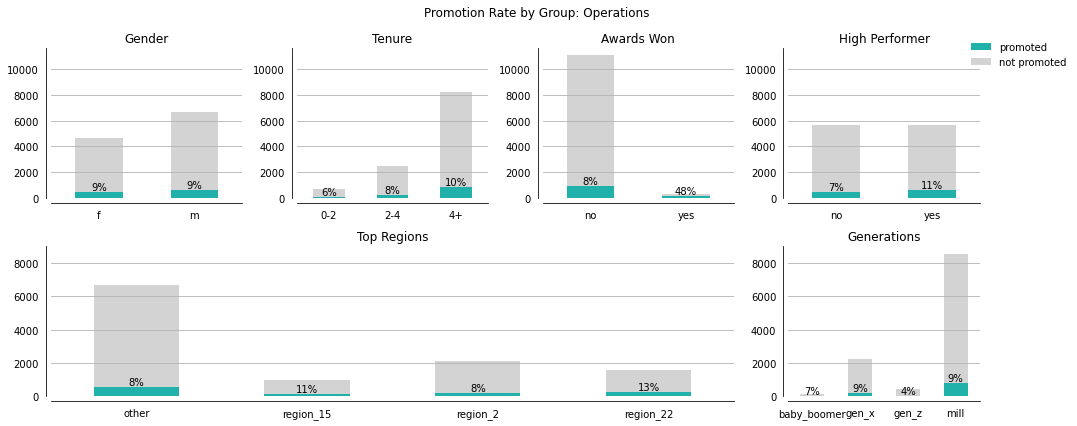

In [32]:
plots.plot_promo_demographics(ops, 'Operations')

In [33]:
ops_mod = smf.glm('is_promoted ~ C(gender,Treatment("m"))', 
               family = sm.families.Binomial(), data = ops) 
ops_res = ops_mod.fit()
ops_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
===============================================================================
Model:                   GLM                   AIC:                 6876.3353  
Link Function:           logit                 BIC:                 -99062.9611
Dependent Variable:      is_promoted           Log-Likelihood:      -3436.2    
Date:                    2022-01-26 17:09      LL-Null:             -3437.1    
No. Observations:        11348                 Deviance:            6872.3     
Df Model:                1                     Pearson chi2:        1.13e+04   
Df Residuals:            11346                 Scale:               1.0000     
Method:                  IRLS                                                  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                      -2.3497   0.0434 -54.1134 0.0000 -2.4348 -2.2645
C(gender, Treatment("m"))[T.f]  0.0898   0.0662   1.3566 0.1749 -0.0399  0.2196
===============================================================================

"""

In [34]:
# llr is difference in null model and saturated model
llr_ops=round(ops_res.null_deviance-ops_res.deviance,2)
print(f'llr: {llr_ops}')

p_val_ops=round(1-stats.chi2.cdf(llr_ops,ops_res.df_model),4)
print(f'p-value:{p_val_ops}')

llr: 1.83
p-value:0.1761


In [35]:
ops_mod1 = smf.glm('is_promoted ~ age_group', 
               family = sm.families.Binomial(), data = ops) 
ops_res1 = ops_mod1.fit()
ops_res1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:                GLM              AIC:            6865.9631  
Link Function:        logit            BIC:            -99058.6598
Dependent Variable:   is_promoted      Log-Likelihood: -3429.0    
Date:                 2022-01-26 17:09 LL-Null:        -3437.1    
No. Observations:     11348            Deviance:       6858.0     
Df Model:             3                Pearson chi2:   1.13e+04   
Df Residuals:         11344            Scale:          1.0000     
Method:               IRLS                                        
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept          -2.6210   0.3662 -7.1577 0.0000 -3.3387 -1.9033
age_group[T.gen_x]  0.2623   0.3738  0.7018 0.4828 -0.4703  0.9950
age_group[T.gen_z] -0.4990   0.4422 -1.1285 0.2591 -1.3656  0.3676
age_group[T.mill]   0.3516   0.3681  0.9553 0.3395 -0.3698  1.0730
==================================================================

"""

In [36]:
# llr is difference in null model and saturated model
llr_ops1=round(ops_res1.null_deviance-ops_res1.deviance,2)
print(f'llr: {llr_ops1}')

p_val_ops1=round(1-stats.chi2.cdf(llr_ops1,ops_res1.df_model),4)
print(f'p-value:{p_val_ops1}')

llr: 16.21
p-value:0.001


In [37]:
ops_mod2 = smf.glm('is_promoted ~ tenure_bands', 
               family = sm.families.Binomial(), data = ops) 
ops_res2 = ops_mod2.fit()
ops_res2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:                GLM               AIC:             6863.9015  
Link Function:        logit             BIC:             -99068.0582
Dependent Variable:   is_promoted       Log-Likelihood:  -3429.0    
Date:                 2022-01-26 17:09  LL-Null:         -3437.1    
No. Observations:     11348             Deviance:        6857.9     
Df Model:             2                 Pearson chi2:    1.13e+04   
Df Residuals:         11345             Scale:           1.0000     
Method:               IRLS                                          
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -2.7279   0.1632 -16.7149 0.0000 -3.0477 -2.4080
tenure_bands[T.2-4]  0.2482   0.1797   1.3808 0.1673 -0.1041  0.6005
tenure_bands[T.4+]   0.4887   0.1674   2.9191 0.0035  0.1606  0.8169
====================================================================

"""

In [38]:
# llr is difference in null model and saturated model
llr_ops2=round(ops_res2.null_deviance-ops_res2.deviance,2)
print(f'llr: {llr_ops2}')

p_val_ops2=round(1-stats.chi2.cdf(llr_ops2,ops_res2.df_model),4)
print(f'p-value:{p_val_ops2}')

llr: 16.27
p-value:0.0003


In [39]:
ops_mod3 = smf.glm('is_promoted ~ awards_won', 
               family = sm.families.Binomial(), data = ops) 
ops_res3 = ops_mod3.fit()
ops_res3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:              GLM              AIC:            6601.7006  
Link Function:      logit            BIC:            -99337.5958
Dependent Variable: is_promoted      Log-Likelihood: -3298.9    
Date:               2022-01-26 17:09 LL-Null:        -3437.1    
No. Observations:   11348            Deviance:       6597.7     
Df Model:           1                Pearson chi2:   1.13e+04   
Df Residuals:       11346            Scale:          1.0000     
Method:             IRLS                                        
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept   -2.4288    0.0348  -69.7728  0.0000  -2.4970  -2.3606
awards_won   2.3371    0.1285   18.1885  0.0000   2.0853   2.5890
================================================================

"""

In [40]:
# llr is difference in null model and saturated model
llr_ops3=round(ops_res3.null_deviance-ops_res3.deviance,2)
print(f'llr: {llr_ops3}')

p_val_ops3=round(1-stats.chi2.cdf(llr_ops3,ops_res3.df_model),4)
print(f'p-value:{p_val_ops3}')

llr: 276.47
p-value:0.0


In [41]:
ops_mod4 = smf.glm('is_promoted ~ high_performer', 
               family = sm.families.Binomial(), data = ops) 
ops_res4 = ops_mod4.fit()
ops_res4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:              GLM              AIC:            6835.5290  
Link Function:      logit            BIC:            -99103.7674
Dependent Variable: is_promoted      Log-Likelihood: -3415.8    
Date:               2022-01-26 17:09 LL-Null:        -3437.1    
No. Observations:   11348            Deviance:       6831.5     
Df Model:           1                Pearson chi2:   1.13e+04   
Df Residuals:       11346            Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -2.5469   0.0512 -49.7828 0.0000 -2.6471 -2.4466
high_performer   0.4319   0.0667   6.4727 0.0000  0.3011  0.5626
================================================================

"""

In [42]:
# llr is difference in null model and saturated model
llr_ops4=round(ops_res4.null_deviance-ops_res4.deviance,2)
print(f'llr: {llr_ops4}')

p_val_ops4=round(1-stats.chi2.cdf(llr_ops4,ops_res4.df_model),4)
print(f'p-value:{p_val_ops4}')

llr: 42.64
p-value:0.0


In [43]:
ops_mod5 = smf.glm('is_promoted ~ region_grps', 
               family = sm.families.Binomial(), data = ops) 
ops_res5 = ops_mod5.fit()
ops_res5.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Generalized linear model
=========================================================================
Model:                 GLM                 AIC:               6838.5506  
Link Function:         logit               BIC:               -99086.0723
Dependent Variable:    is_promoted         Log-Likelihood:    -3415.3    
Date:                  2022-01-26 17:09    LL-Null:           -3437.1    
No. Observations:      11348               Deviance:          6830.6     
Df Model:              3                   Pearson chi2:      1.13e+04   
Df Residuals:          11344               Scale:             1.0000     
Method:                IRLS                                              
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                -2.4450   0.0451 -54.2501 0.0000 -2.5334 -2.3567
region_grps[T.region_15]  0.3313   0.1132   2.9276 0.0034  0.1095  0.5531
region_grps[T.region_2]   0.0548   0.0902   0.6075 0.5435 -0.1219  0.2315
region_grps[T.region_22]  0.5669   0.0875   6.4790 0.0000  0.3954  0.7383
=========================================================================

"""

In [44]:
# llr is difference in null model and saturated model
llr_ops5=round(ops_res5.null_deviance-ops_res5.deviance,2)
print(f'llr: {llr_ops5}')

p_val_ops5=round(1-stats.chi2.cdf(llr_ops5,ops_res5.df_model),4)
print(f'p-value:{p_val_ops5}')

llr: 43.62
p-value:0.0


In [45]:
## Check for correlation between categorical variables
awards_performer = round(sm.stats.Table.from_data(ops[['awards_won','high_performer']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of awards_won and high_performer is {awards_performer}')

age_tenure = round(sm.stats.Table.from_data(ops[['age_group','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of age_group and tenure is {age_tenure}')

awards_tenure = round(sm.stats.Table.from_data(ops[['awards_won','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of awards and tenure is {awards_tenure}')

high_perf_tenure = round(sm.stats.Table.from_data(ops[['high_performer','tenure_bands']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and tenure is {high_perf_tenure}')

high_perf_region = round(sm.stats.Table.from_data(ops[['high_performer','region_grps']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and region is {high_perf_region}')

high_perf_age = round(sm.stats.Table.from_data(ops[['high_performer','age_group']]).test_nominal_association().pvalue, 3)
print(f'p-value of the chi-square test of high performer and age group is {high_perf_age}')


p-value of the chi-square test of awards_won and high_performer is 0.536
p-value of the chi-square test of age_group and tenure is 0.0
p-value of the chi-square test of awards and tenure is 0.605
p-value of the chi-square test of high performer and tenure is 0.0
p-value of the chi-square test of high performer and region is 0.004
p-value of the chi-square test of high performer and age group is 0.0


In [46]:
# Step 1 - Create a main effects model 
ops_mod6 = smf.glm('is_promoted ~ awards_won + high_performer', 
               family = sm.families.Binomial(), data = ops) 
ops_res6 = ops_mod6.fit()
ops_res6.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:              GLM              AIC:            6560.8734  
Link Function:      logit            BIC:            -99371.0862
Dependent Variable: is_promoted      Log-Likelihood: -3277.4    
Date:               2022-01-26 17:09 LL-Null:        -3437.1    
No. Observations:   11348            Deviance:       6554.9     
Df Model:           2                Pearson chi2:   1.14e+04   
Df Residuals:       11345            Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -2.6704   0.0533 -50.0588 0.0000 -2.7749 -2.5658
awards_won       2.3478   0.1293  18.1551 0.0000  2.0943  2.6013
high_performer   0.4425   0.0682   6.4856 0.0000  0.3088  0.5763
================================================================

"""

In [47]:
ops_awards_hipo = ops.groupby(['awards_won','high_performer', 
                               'is_promoted'])['employee_id'].count().unstack('is_promoted').reset_index()
ops_awards_hipo.rename(columns = {1:'yes', 0:'no'}, inplace = True)

ops_awards_hipo.fillna(0,inplace=True)

In [48]:
ops_mod_grouped = smf.glm('yes + no ~ awards_won + high_performer', 
               family=sm.families.Binomial(), data = ops_awards_hipo)
ops_res_grouped = ops_mod_grouped.fit()
ops_res_grouped.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          ['yes', 'no']   No. Observations:                    4
Model:                            GLM   Df Residuals:                        1
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13.660
Date:                Wed, 26 Jan 2022   Deviance:                       1.0398
Time:                        17:09:32   Pearson chi2:                     1.03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.6704      0.053    -50.059      0.000      -2.775      -2.566
awards_won         2.3478      0.129     18.155      0.000       2.094       2.601
high_performer     0.4425      0.068      6.486      0.000       0.309       0.576
==================================================================================
"""

In [49]:
inf = ops_res_grouped.get_influence()
inf.summary_frame()

,dfb_Intercept,dfb_awards_won,dfb_high_performer,cooks_d,standard_resid,hat_diag,dffits_internal
0,4.72153,-0.95856,-3.57298,7.43095,1.01723,0.95564,4.72153
1,-0.21916,1.07950,-3.57298,10.91973,-1.01723,0.96938,-5.72356
2,-0.21916,-0.95856,0.28961,0.36580,-1.01723,0.51469,-1.04756
3,-0.21916,1.07950,0.28961,0.43951,1.01723,0.56029,1.14827


In [50]:
# can add the fitted values from the model to our dataframe and observe that all of the expected values are at least 5
ops_awards_hipo['fitted_yes'] = ops_res_grouped.fittedvalues * (ops_awards_hipo.yes + ops_awards_hipo.no)
ops_awards_hipo['fitted_no'] = (1 - ops_res_grouped.fittedvalues) * (ops_awards_hipo.yes + ops_awards_hipo.no)


In [51]:
ops.tenure_bands.value_counts()

4+     8225
2-4    2471
0-2     652
Name: tenure_bands, dtype: int64

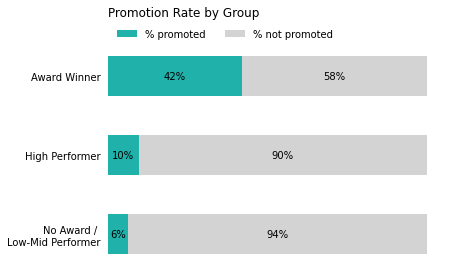

In [52]:
# plot results 
pct_promoted = ops_res_grouped.fittedvalues.sort_values()[:3]
labels = ['No Award / \nLow-Mid Performer', 'High Performer', 'Award Winner']
plots.plot_fitted_values(labels, pct_promoted)